In [1]:
%load_ext autoreload
%autoreload 2

import click
import pickle
from tqdm import tqdm
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sbi.inference import FMPE
import os
from utils.data_generation import fetch_grid, transform_meas, sample_joint_distribution, sample_uniform_distribution
from utils.inference import preprocess_inputs, get_prior, get_eval_grid, get_posterior, posterior_and_prior_kdeplot
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions

2024-12-16 10:29:22.295981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 10:29:22.296042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 10:29:22.298420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 10:29:22.306942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 10:29:23.712406: W tensorflow/compiler/tf2

In [2]:
FLOW_TYPE = 'npe'
B = 300_000  # num simulations to estimate posterior anid test statistics
B_PRIME = 50_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 10_000  # num simulations to estimate critical values
EVAL_GRID_SIZE = 50_000
DISPLAY_GRID_SIZE = 10
NORM_POSTERIOR_SAMPLES = None
CONFIDENCE_LEVEL = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

POI_DIM = 5
POIS = ['t_eff', 'logg', 'feh_surf', 'logl', 'dist']
LABELS = [r"$T_{eff}$ (K)", r"$\log g$ (cgs)", r"$[\text{Fe/H}]_{\text{surf}}$ (relative to solar)", r"$\log L$ ($L_{\odot}$)", r"$d$ (kpc)"]
PRIOR_SETTINGS = [-2.0, -1.0, 0.0, 1.0, 2.0]
PRIOR_ARGS = {
    'lower_bound' : torch.tensor([2.5e3, 0.0, -4.0, -1.5, 0.0]),
    'upper_bound' : torch.tensor([1.5e4, 5.0, 0.5, 3.5, 1.0e3])
}
PLOT_PRIORS = False

assets_dir = f'{os.getcwd()}/assets'
os.makedirs(assets_dir, exist_ok=True)
params, seds = fetch_grid(assets_dir=assets_dir) # POI grid + raw SEDs

# 1. VIEW PRIORS

In [3]:
# Set up directories
prior_samples = []

for PRIOR_SETTING in PRIOR_SETTINGS:
    # Get prior
    try:
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'rb') as f:
            prior = pickle.load(f)
    except:
        theta, x = sample_joint_distribution(params=params,
                                            seds=seds,
                                            args={'age_feh_hyperparam': PRIOR_SETTING,},
                                            n_samples=B,
                                            assets_dir=assets_dir,)
        theta_p, x_p = preprocess_inputs(theta, x, ['t_eff', 'logg', 'feh_surf', 'logl', 'dist'])
        prior = get_prior(theta_p, prior_args=PRIOR_ARGS)
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'wb') as f:
            pickle.dump(prior, f)

    prior_samples.append(prior.sample((1_000,)))

In [4]:
if PLOT_PRIORS:
    theta_dfs = []
    # Convert theta to a pandas DataFrame
    for i, prior_sample in enumerate(prior_samples):
        theta_df_i = pd.DataFrame(prior_sample.numpy(), columns=LABELS)
        theta_df_i['set'] = str(i+1)
        theta_dfs.append(theta_df_i)

    # Convert theta to a pandas DataFrame
    theta_df = pd.concat(theta_dfs)

    # Create pairwise heatmaps
    palette = ["#ca0020", "#f4a582", "#f7f7f7", "#92c5de", "#0571b0"]
    g = sns.pairplot(data=theta_df,
                        hue='set',
                        palette=sns.color_palette(palette, 5),
                        kind='kde',
                        diag_kind='hist')

    for ax in g.axes.ravel():
        ax.invert_xaxis()
        ax.invert_yaxis()

    plt.show() # plt.savefig(f'{assets_dir}/prior_heatmap.png')

# 2. DATA GENERATION

## 2a. Look at clusters and display points

In [5]:
try:
    with open(f'{assets_dir}/tryout_evaluation_grid.pkl', 'rb') as f:
        theta_e_c, x_e_c = pickle.load(f)
except:
    theta_e, x_e = sample_uniform_distribution(params, seds, EVAL_GRID_SIZE)
    theta_e_c, x_e_c = preprocess_inputs(theta_e, x_e, POIS)
    with open(f'{assets_dir}/tryout_evaluation_grid.pkl', 'wb') as f:
        pickle.dump((theta_e_c, x_e_c), f)

In [6]:
import pickle
import numpy as np
import random
from brutus import seds as bseds
from brutus import utils as butils
from brutus import filters
from brutus import pdf
import numpy.lib.recfunctions as rfn


def fetch_display_set(assets_dir):
    """
    This method gets the SEDmaker which generates three grids:
    - Labels, e.g. intrinsic parameters
    - Params, e.g. surface-level parameters
    - SEDs, e.g. spectral energy distributions, with reddening, by default at
        distance 1000
    Each of these grids are structured numpy arrays, meaning that their rows are
    tuples corresponding with individual stars. Their dtypes contain names of
    the fields that represent the stars on each corresponding level.
    """
    try:
        with open(f'{assets_dir}/mist_display.pkl', 'rb') as f:
            mist = pickle.load(f)
    except:
        mist = bseds.SEDmaker(nnfile=f'{assets_dir}/nn_c3k.h5',
                        mistfile=f'{assets_dir}/MIST_1.2_EEPtrk.h5')
        # build the SED grid
        mist.make_grid(mini_grid=np.array([0.5, 2.0]),
                       feh_grid=np.linspace(-3.0, 0.5, 5),
                       eep_grid=np.linspace(202, 808, 5),
                       afe_grid=np.array([0.0]),
                       smf_grid=np.array([0.0]))
        with open(f'{assets_dir}/mist_display.pkl', 'wb') as f:
            pickle.dump(mist, f)

    # Get a mask for successful parameter inputs
    sel = mist.grid_sel

    # Get the labels and params and seds
    labels = mist.grid_label[sel]
    params = mist.grid_param[sel]
    seds = mist.grid_sed[sel]

    # Do some basic transforms on the labels and params
    params = rfn.append_fields(params, 't_eff', 10**params['logt'], usemask=False)
    params = rfn.append_fields(params, 'age', 10**params['loga'], usemask=False)
    params = rfn.merge_arrays((labels, params),
                            flatten=True,
                            usemask=False)

    # Subselect the filters
    filt = filters.ps[:-2] + filters.tmass
    stype = np.dtype([(f, '<f8', (3,)) for f in filt])
    seds = np.array(seds[filt].tolist(), dtype=stype)

    return params, seds

In [7]:
display_params, display_seds = fetch_display_set(assets_dir=assets_dir)

In [8]:
# Fix extrinsic parameters
av = 0.6 * np.ones(display_params.shape[0]*3)
rv = 3.1 * np.ones(display_params.shape[0]*3)
dist1 = 3e-1 * np.ones(display_params.shape[0])
dist2 = 3 * np.ones(display_params.shape[0])
dist3 = 3e1 * np.ones(display_params.shape[0])
dist = np.array([dist1, dist2, dist3]).T.flatten()

In [9]:
display_params = display_params.repeat(3)
display_seds = display_seds.repeat(3)

In [10]:
try:
    display_params = rfn.append_fields(display_params, 'av', av, usemask=False)
    display_params = rfn.append_fields(display_params, 'rv', rv, usemask=False)
    display_params = rfn.append_fields(display_params, 'dist', dist, usemask=False)
except:
    pass
display_params.shape, display_params.dtype.names

((72,),
 ('mini',
  'eep',
  'feh',
  'afe',
  'smf',
  'loga',
  'logl',
  'logt',
  'logg',
  'feh_surf',
  'afe_surf',
  'agewt',
  't_eff',
  'age',
  'av',
  'rv',
  'dist'))

In [11]:
# Define the input and output structures
ptype = display_params.dtype
stype = display_seds.dtype
mtype = np.dtype([(name, dtype, (1,)) for name, dtype, shape in stype.descr] + [('norm', np.float64, (1,))])

# 2. Evaluate the likelihood
## Redden the magnitudes of the seds
mag_coeffs = np.vstack([np.array(sed.tolist()).reshape(1, -1, 3) for sed in display_seds]) # Unstructured (n_samples, n_filters, 3) np.ndarray
reddened_seds = butils.get_seds(mag_coeffs, display_params['av'], display_params['rv'])

## Correct the default distance modulus to the sampled distance modulus
reddened_seds = transform_meas(display_params, reddened_seds)

## Normalize measurements (while retaining one raw magnitude for comparison)
magnitudes = np.linalg.norm(reddened_seds, axis=1).reshape(-1, 1)
reddened_seds = np.hstack([reddened_seds / magnitudes, magnitudes])

# Revert to structured array
display_seds = np.array([tuple(sed) for sed in reddened_seds], dtype=mtype) # Structured (n_samples,) np.ndarray

In [12]:
with open(f'{assets_dir}/tryout_display_grid.pkl', 'wb') as f:
    theta_d_c, x_d_c = preprocess_inputs(display_params, display_seds, POIS)
    pickle.dump((theta_d_c, x_d_c), f)

In [15]:
try:
    with open(f'{assets_dir}/tryout_display_grid_labels.pkl', 'rb') as f:
        point_labels = pickle.load(f)
    with open(f'{assets_dir}/tryout_display_grid_labels_without_dist.pkl', 'rb') as f:
        point_labels_without_dist = pickle.load(f)
except:
    isochrone_indices = np.unique(display_params[['mini', 'feh']]).tolist()
    isochrone_names = list(map(chr, range(65, 65 + len(isochrone_indices))))
    star_names = dict(zip(isochrone_indices, isochrone_names))

    age_indices = np.unique(display_params['eep']).tolist()
    star_ages = dict(zip(age_indices, list(range(1, len(age_indices) + 1))))

    star_dists = dict(zip([3e-1, 3, 3e1], ['03kpc', '3kpc', '30kpc']))

    point_labels = []
    point_labels_without_dist = []
    for idx, param in enumerate(display_params):
        star_name = star_names[(param['mini'], param['feh'])]
        star_age = str(star_ages[param['eep']])
        star_dist = star_dists[param['dist']]
        point_labels.append(f'{star_name}{star_age}_{star_dist}')
        if f'{star_name}{star_age}' not in point_labels_without_dist:
            point_labels_without_dist.append(f'{star_name}{star_age}')

    with open(f'{assets_dir}/tryout_display_grid_labels.pkl', 'wb') as f:
        pickle.dump(point_labels, f)
    with open(f'{assets_dir}/tryout_display_grid_labels_without_dist.pkl', 'wb') as f:
        pickle.dump(point_labels_without_dist, f)

In [22]:
theta_d_c[::3, :-1].shape

torch.Size([24, 4])

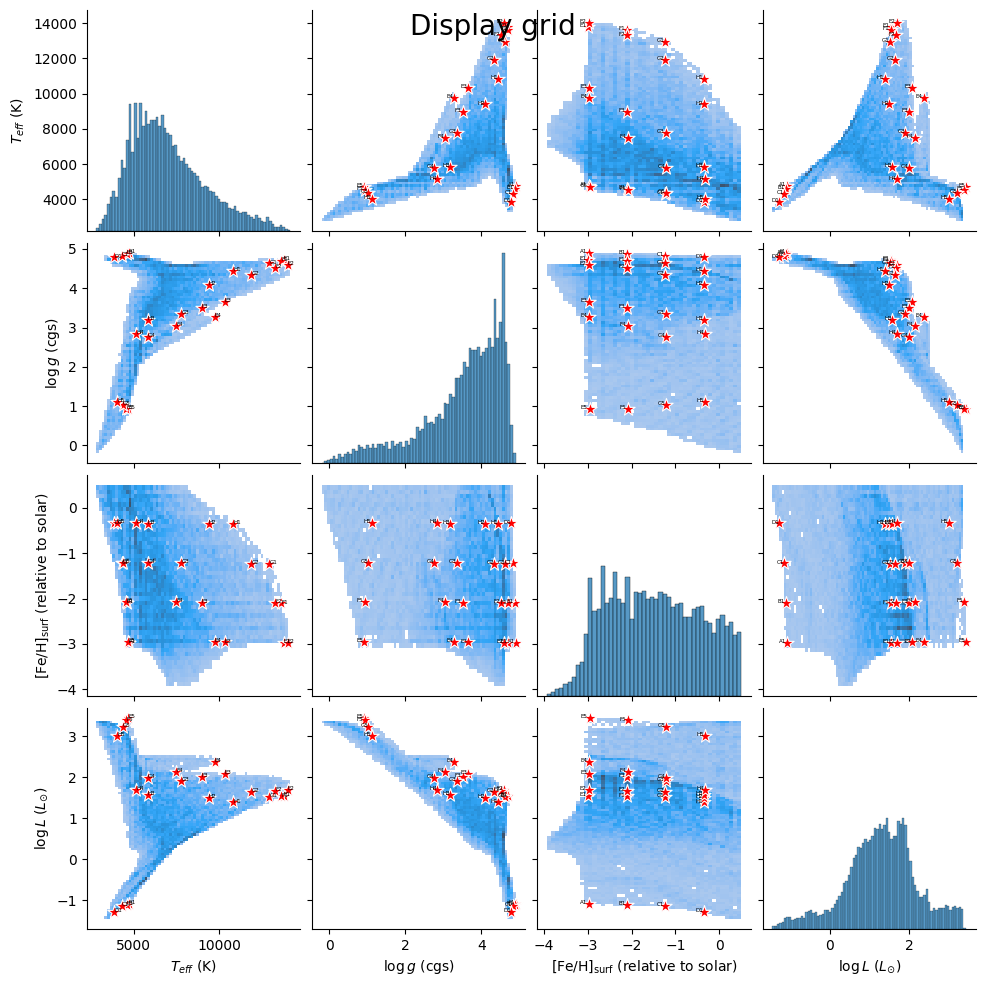

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert theta_calib to a pandas DataFrame
theta_calib_df = pd.DataFrame(theta_e_c[:, :-1], columns=LABELS[:-1])
theta_display_df = pd.DataFrame(theta_d_c[::3, :-1], columns=LABELS[:-1])
theta_display_df['label'] = [f'{label[:2]}' for label in point_labels[::3]]

# Plot pairplots
g = sns.pairplot(data=theta_calib_df, diag_kind='hist', kind='hist')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-.2, point['y'], str(point['val']), fontsize=4)

for ax in g.axes.ravel():
    if ax.get_xlabel() and ax.get_ylabel():
        sns.scatterplot(data=theta_display_df, x=ax.get_xlabel(), y=ax.get_ylabel(), color='red', marker='*', s=100, ax=ax)
        label_point(theta_display_df[ax.get_xlabel()], theta_display_df[ax.get_ylabel()], theta_display_df['label'], ax)
    ax.invert_xaxis()
    ax.invert_yaxis()

plt.suptitle(f'Display grid', fontsize=20)
plt.savefig(f'{assets_dir}/display_grid_pairs.png')
plt.show()
plt.close()

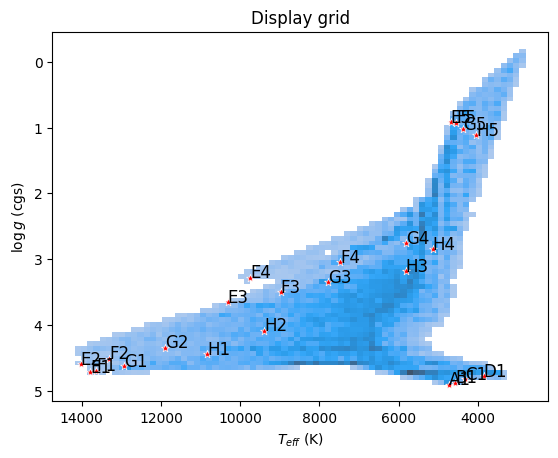

In [26]:
# Just do first pair of params
sns.histplot(data=theta_calib_df, x=LABELS[0], y=LABELS[1])
sns.scatterplot(data=theta_display_df, x=LABELS[0], y=LABELS[1], color='red', marker='*')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-.2, point['y'], str(point['val']), fontsize=12)

label_point(theta_display_df[LABELS[0]], theta_display_df[LABELS[1]], theta_display_df['label'], plt.gca())

plt.title('Display grid')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.savefig(f'{assets_dir}/display_grid_teff_logg.png')
plt.show()
plt.close()